We already have the sequence data for resistant and susceptible. need to convert the sequence data into a CSV with a new column called 'resistance' and 'isolate_name'

In [2]:
from Bio import SeqIO
import polars as pl

def fasta_to_polars(fasta_file: str, phenotype_label: str) -> pl.DataFrame:
    """
    Converts a FASTA file into a Polars DataFrame with ordinally encoded nucleotides.
    Each nucleotide (A,T,G,C,N) is mapped to integers (0–4).
    """
    nuc_map = {"A": 0, "T": 1, "G": 2, "C": 3, "N": 4}

    records = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        seq_str = str(record.seq).upper()
        encoded_seq = [nuc_map.get(base, 4) for base in seq_str]
        encoded_seq.append(1 if phenotype_label == "resistant" else 0)
        records.append(encoded_seq)

    num_positions = len(records[0]) - 1
    columns = [f"pos_{i+1}" for i in range(num_positions)] + ["phenotype"]

    return pl.DataFrame(records, schema=columns)


# === Example usage ===
resistant_fasta = r"C:\Users\Noah Legall\LegallLab\SHAP-mTB-AMR\resistance_dataset\rifampicin_resistant_rpoBC.fasta"
susceptible_fasta = r"C:\Users\Noah Legall\LegallLab\SHAP-mTB-AMR\resistance_dataset\rifampicin_susceptible_rpoBC.fasta"

# Convert each FASTA to labeled DataFrame
resistant_df = fasta_to_polars(resistant_fasta, "resistant")
susceptible_df = fasta_to_polars(susceptible_fasta, "susceptible")

# Combine both into one dataset
combined_df = pl.concat([resistant_df, susceptible_df])

# Save to CSV
combined_df.write_csv("rpoBC_fullseq.csv")

print("✅ Data saved to rpoBC_fullseq.csv")
print(combined_df.head())


C:\Users\Noah Legall\AppData\Local\Temp\ipykernel_6028\3601686267.py:21: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  return pl.DataFrame(records, schema=columns)


✅ Data saved to rpoBC_fullseq.csv
shape: (5, 7_911)
┌───────┬───────┬───────┬───────┬───┬──────────┬──────────┬──────────┬───────────┐
│ pos_1 ┆ pos_2 ┆ pos_3 ┆ pos_4 ┆ … ┆ pos_7908 ┆ pos_7909 ┆ pos_7910 ┆ phenotype │
│ ---   ┆ ---   ┆ ---   ┆ ---   ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---       │
│ i64   ┆ i64   ┆ i64   ┆ i64   ┆   ┆ i64      ┆ i64      ┆ i64      ┆ i64       │
╞═══════╪═══════╪═══════╪═══════╪═══╪══════════╪══════════╪══════════╪═══════════╡
│ 1     ┆ 2     ┆ 3     ┆ 3     ┆ … ┆ 1        ┆ 0        ┆ 2        ┆ 1         │
│ 1     ┆ 2     ┆ 3     ┆ 3     ┆ … ┆ 1        ┆ 0        ┆ 2        ┆ 1         │
│ 1     ┆ 2     ┆ 3     ┆ 3     ┆ … ┆ 1        ┆ 0        ┆ 2        ┆ 1         │
│ 1     ┆ 2     ┆ 3     ┆ 3     ┆ … ┆ 1        ┆ 0        ┆ 2        ┆ 1         │
│ 1     ┆ 2     ┆ 3     ┆ 3     ┆ … ┆ 1        ┆ 0        ┆ 2        ┆ 1         │
└───────┴───────┴───────┴───────┴───┴──────────┴──────────┴──────────┴───────────┘


We have position-wise nucleotide data with phenotype labels in 'rpoBC_fullseq.csv'.

Now, we need to prep this data to be read by ML models. Plan to do a bit of benchmarking 

In [2]:
import polars as pl

data = pl.read_csv(r'C:\Users\Noah Legall\LegallLab\SHAP-mTB-AMR\scripts\rpoBC_fullseq.csv')
data

pos_1,pos_2,pos_3,pos_4,pos_5,pos_6,pos_7,pos_8,pos_9,pos_10,pos_11,pos_12,pos_13,pos_14,pos_15,pos_16,pos_17,pos_18,pos_19,pos_20,pos_21,pos_22,pos_23,pos_24,pos_25,pos_26,pos_27,pos_28,pos_29,pos_30,pos_31,pos_32,pos_33,pos_34,pos_35,pos_36,pos_37,…,pos_7875,pos_7876,pos_7877,pos_7878,pos_7879,pos_7880,pos_7881,pos_7882,pos_7883,pos_7884,pos_7885,pos_7886,pos_7887,pos_7888,pos_7889,pos_7890,pos_7891,pos_7892,pos_7893,pos_7894,pos_7895,pos_7896,pos_7897,pos_7898,pos_7899,pos_7900,pos_7901,pos_7902,pos_7903,pos_7904,pos_7905,pos_7906,pos_7907,pos_7908,pos_7909,pos_7910,phenotype
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
1,2,3,3,3,0,3,3,1,3,0,3,3,3,2,3,3,0,3,1,1,2,0,3,0,3,3,2,1,2,2,1,3,4,1,1,0,…,3,3,2,3,1,2,2,0,3,2,0,3,1,0,3,2,2,3,1,0,3,0,2,3,2,0,3,1,0,3,3,2,3,1,0,2,1
1,2,3,3,3,0,3,3,1,3,0,3,3,3,2,3,3,0,3,1,1,2,0,3,0,3,3,2,1,2,2,1,3,4,1,1,0,…,3,3,2,3,1,2,2,0,3,2,0,3,1,0,3,2,2,3,1,0,3,0,2,3,2,0,3,1,0,3,3,2,3,1,0,2,1
1,2,3,3,3,0,3,3,1,3,0,3,3,3,2,3,3,0,3,1,1,2,0,3,0,3,3,2,1,2,2,1,3,4,1,1,0,…,3,3,2,3,1,2,2,0,3,2,0,3,1,0,3,2,2,3,1,0,3,0,2,3,2,0,3,1,0,3,3,2,3,1,0,2,1
1,2,3,3,3,0,3,3,1,3,0,3,3,3,2,3,3,0,3,1,1,2,0,3,0,3,3,2,1,2,2,1,3,4,1,1,0,…,3,3,2,3,1,2,2,0,3,2,0,3,1,0,3,2,2,3,1,0,3,0,2,3,2,0,3,1,0,3,3,2,3,1,0,2,1
1,2,3,3,3,0,3,3,1,3,0,3,3,3,2,3,3,0,3,1,1,2,0,3,0,3,3,2,1,2,2,1,3,4,1,1,0,…,3,3,2,3,1,2,2,0,3,2,0,3,1,0,3,2,2,3,1,0,3,0,2,3,2,0,3,1,0,3,3,2,3,1,0,2,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1,2,3,3,3,0,3,3,1,3,0,3,3,3,2,3,3,0,3,1,1,2,0,3,0,3,3,2,1,2,2,1,3,4,1,1,0,…,3,3,2,3,1,2,2,0,3,2,0,3,1,0,3,2,2,3,1,0,3,0,2,3,2,0,3,1,0,3,3,2,3,1,0,2,0
1,2,3,3,3,0,3,3,1,3,0,3,3,3,2,3,3,0,3,1,1,2,0,3,0,3,3,2,1,2,2,1,3,4,1,1,0,…,3,3,2,3,1,2,2,0,3,2,0,3,1,0,3,2,2,3,1,0,3,0,2,3,2,0,3,1,0,3,3,2,3,1,0,2,0
1,2,3,3,3,0,3,3,1,3,0,3,3,3,2,3,3,0,3,1,1,2,0,3,0,3,3,2,1,2,2,1,3,4,1,1,0,…,3,3,2,3,1,2,2,0,3,2,0,3,1,0,3,2,2,3,1,0,3,0,2,3,2,0,3,1,0,3,3,2,3,1,0,2,0


Run this one if running on my personal laptop

In [3]:
import polars as pl

data = pl.read_csv(r'C:\Users\noah_\SHAP-mTB-AMR\scripts\rpoBC_fullseq.csv')
data

pos_1,pos_2,pos_3,pos_4,pos_5,pos_6,pos_7,pos_8,pos_9,pos_10,pos_11,pos_12,pos_13,pos_14,pos_15,pos_16,pos_17,pos_18,pos_19,pos_20,pos_21,pos_22,pos_23,pos_24,pos_25,pos_26,pos_27,pos_28,pos_29,pos_30,pos_31,pos_32,pos_33,pos_34,pos_35,pos_36,pos_37,…,pos_7875,pos_7876,pos_7877,pos_7878,pos_7879,pos_7880,pos_7881,pos_7882,pos_7883,pos_7884,pos_7885,pos_7886,pos_7887,pos_7888,pos_7889,pos_7890,pos_7891,pos_7892,pos_7893,pos_7894,pos_7895,pos_7896,pos_7897,pos_7898,pos_7899,pos_7900,pos_7901,pos_7902,pos_7903,pos_7904,pos_7905,pos_7906,pos_7907,pos_7908,pos_7909,pos_7910,phenotype
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
1,2,3,3,3,0,3,3,1,3,0,3,3,3,2,3,3,0,3,1,1,2,0,3,0,3,3,2,1,2,2,1,3,4,1,1,0,…,3,3,2,3,1,2,2,0,3,2,0,3,1,0,3,2,2,3,1,0,3,0,2,3,2,0,3,1,0,3,3,2,3,1,0,2,1
1,2,3,3,3,0,3,3,1,3,0,3,3,3,2,3,3,0,3,1,1,2,0,3,0,3,3,2,1,2,2,1,3,4,1,1,0,…,3,3,2,3,1,2,2,0,3,2,0,3,1,0,3,2,2,3,1,0,3,0,2,3,2,0,3,1,0,3,3,2,3,1,0,2,1
1,2,3,3,3,0,3,3,1,3,0,3,3,3,2,3,3,0,3,1,1,2,0,3,0,3,3,2,1,2,2,1,3,4,1,1,0,…,3,3,2,3,1,2,2,0,3,2,0,3,1,0,3,2,2,3,1,0,3,0,2,3,2,0,3,1,0,3,3,2,3,1,0,2,1
1,2,3,3,3,0,3,3,1,3,0,3,3,3,2,3,3,0,3,1,1,2,0,3,0,3,3,2,1,2,2,1,3,4,1,1,0,…,3,3,2,3,1,2,2,0,3,2,0,3,1,0,3,2,2,3,1,0,3,0,2,3,2,0,3,1,0,3,3,2,3,1,0,2,1
1,2,3,3,3,0,3,3,1,3,0,3,3,3,2,3,3,0,3,1,1,2,0,3,0,3,3,2,1,2,2,1,3,4,1,1,0,…,3,3,2,3,1,2,2,0,3,2,0,3,1,0,3,2,2,3,1,0,3,0,2,3,2,0,3,1,0,3,3,2,3,1,0,2,1
1,2,3,3,3,0,3,3,1,3,0,3,3,3,2,3,3,0,3,1,1,2,0,3,0,3,3,2,1,2,2,1,3,4,1,1,0,…,3,3,2,3,1,2,2,0,3,2,0,3,1,0,3,2,2,3,1,0,3,0,2,3,2,0,3,1,0,3,3,2,3,1,0,2,1
1,2,3,3,3,0,3,3,1,3,0,3,3,3,2,3,3,0,3,1,1,2,0,3,0,3,3,2,1,2,2,1,3,4,1,1,0,…,3,3,2,3,1,2,2,0,3,2,0,3,1,0,3,2,2,3,1,0,3,0,2,3,2,0,3,1,0,3,3,2,3,1,0,2,1
1,2,3,3,3,0,3,3,1,3,0,3,3,3,2,3,3,0,3,1,1,2,0,3,0,3,3,2,1,2,2,1,3,4,1,1,0,…,3,3,2,3,1,2,2,0,3,2,0,3,1,0,3,2,2,3,1,0,3,0,2,3,2,0,3,1,0,3,3,2,3,1,0,2,1
1,2,3,3,3,0,3,3,1,3,0,3,3,3,2,3,3,0,3,1,1,2,0,3,0,3,3,2,1,2,2,1,3,4,1,1,0,…,3,3,2,3,1,2,2,0,3,2,0,3,1,0,3,2,2,3,1,0,3,0,2,3,2,0,3,1,0,3,3,2,3,1,0,2,1


# Random Forest

In [2]:
import fasttreeshap

IPython could not be loaded!


In [3]:
# Identify all positional columns (those starting with "pos_")
pos_cols = [col for col in data.columns if col.startswith("pos_")]

# Keep only columns where more than one unique nucleotide value appears
variable_pos = [
    col for col in pos_cols
    if data.select(pl.col(col).n_unique()).item() > 1
]

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# this piece of code doesn't work in the way I think it should
# Actually it does work, I just don't know what the actual column index is
# extract the column names first during the initial data processing step
var_columnns = data.select(variable_pos).columns
print(var_columnns)
X = data.select(variable_pos).to_numpy()
y = data["phenotype"].to_numpy()

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)
rf_acc = accuracy_score(y_test, rf.predict(X_test))
print("🌲 Random Forest accuracy:", rf_acc)


['pos_6', 'pos_7', 'pos_10', 'pos_11', 'pos_17', 'pos_19', 'pos_22', 'pos_25', 'pos_29', 'pos_31', 'pos_34', 'pos_38', 'pos_39', 'pos_41', 'pos_45', 'pos_50', 'pos_51', 'pos_52', 'pos_68', 'pos_75', 'pos_76', 'pos_80', 'pos_89', 'pos_96', 'pos_106', 'pos_108', 'pos_119', 'pos_123', 'pos_124', 'pos_131', 'pos_138', 'pos_142', 'pos_143', 'pos_144', 'pos_145', 'pos_152', 'pos_154', 'pos_155', 'pos_160', 'pos_161', 'pos_184', 'pos_199', 'pos_212', 'pos_216', 'pos_239', 'pos_249', 'pos_255', 'pos_258', 'pos_260', 'pos_266', 'pos_274', 'pos_276', 'pos_281', 'pos_284', 'pos_286', 'pos_289', 'pos_291', 'pos_292', 'pos_304', 'pos_311', 'pos_312', 'pos_314', 'pos_318', 'pos_319', 'pos_328', 'pos_335', 'pos_337', 'pos_338', 'pos_339', 'pos_342', 'pos_344', 'pos_349', 'pos_353', 'pos_354', 'pos_356', 'pos_358', 'pos_361', 'pos_387', 'pos_400', 'pos_409', 'pos_411', 'pos_417', 'pos_429', 'pos_433', 'pos_435', 'pos_442', 'pos_449', 'pos_460', 'pos_464', 'pos_470', 'pos_481', 'pos_489', 'pos_490', 'p

In [8]:
import numpy as np
print(np.unique(X[:,341])) 
print(np.unique(X[:,341]))
print(np.unique(data.to_numpy()[:,341]))
 # Example: Check unique values at position 342

[0 1 2 3 4]
[0 1 2 3 4]
[0 3]


Looking at the average depth of the trees in the model since this is a major factor in why SHAP is takiong so long.

In [6]:
import numpy as np

# Assume your model is named 'rf'
tree_depths = [estimator.tree_.max_depth for estimator in rf.estimators_]
average_depth = np.mean(tree_depths)

print(f"Average tree depth: {average_depth:.2f}")

Average tree depth: 168.60


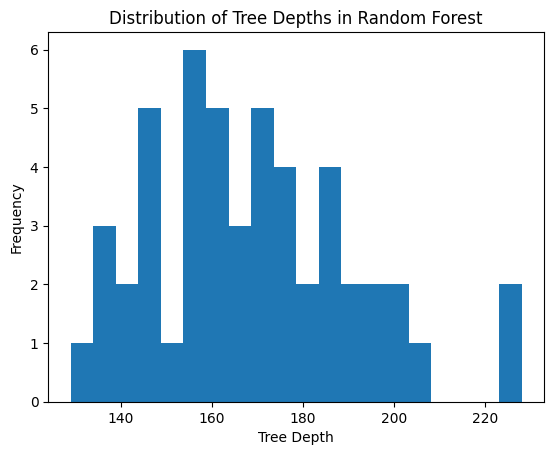

In [7]:
import matplotlib.pyplot as plt

plt.hist(tree_depths, bins=20)
plt.xlabel("Tree Depth")
plt.ylabel("Frequency")
plt.title("Distribution of Tree Depths in Random Forest")
plt.show()

Feature Selection

In [5]:
import numpy as np

importance = rf.feature_importances_
print(importance)
top_idx = sorted(np.argsort(importance)[-100:])  # keep top 100
print(top_idx)
X_top = X[:, top_idx]

[1.52466845e-06 3.43373590e-05 1.12577204e-06 ... 9.61727295e-07
 2.86057324e-04 0.00000000e+00]
[32, 66, 67, 69, 105, 129, 131, 133, 210, 251, 252, 258, 265, 276, 278, 290, 291, 293, 294, 295, 304, 305, 306, 311, 316, 317, 322, 323, 324, 329, 330, 331, 336, 340, 341, 342, 347, 358, 366, 368, 371, 375, 446, 467, 512, 514, 524, 539, 571, 578, 598, 599, 628, 635, 658, 674, 684, 735, 738, 739, 774, 775, 835, 867, 868, 874, 875, 879, 887, 893, 894, 905, 907, 909, 910, 912, 915, 916, 923, 927, 928, 939, 942, 950, 954, 963, 965, 975, 1007, 1032, 1047, 1072, 1168, 1169, 1208, 1210, 1211, 1238, 1273, 1317]


In [6]:
#the top index for var_columnms
top_columns = [var_columnns[i] for i in top_idx]
print(top_columns)

['pos_143', 'pos_337', 'pos_338', 'pos_342', 'pos_524', 'pos_716', 'pos_719', 'pos_724', 'pos_1099', 'pos_1438', 'pos_1440', 'pos_1468', 'pos_1512', 'pos_1529', 'pos_1531', 'pos_1543', 'pos_1544', 'pos_1546', 'pos_1547', 'pos_1548', 'pos_1557', 'pos_1558', 'pos_1559', 'pos_1564', 'pos_1576', 'pos_1577', 'pos_1584', 'pos_1585', 'pos_1586', 'pos_1591', 'pos_1592', 'pos_1593', 'pos_1601', 'pos_1606', 'pos_1607', 'pos_1608', 'pos_1613', 'pos_1696', 'pos_1720', 'pos_1729', 'pos_1735', 'pos_1744', 'pos_1952', 'pos_2038', 'pos_2382', 'pos_2392', 'pos_2501', 'pos_2592', 'pos_2789', 'pos_2814', 'pos_2937', 'pos_2944', 'pos_3227', 'pos_3243', 'pos_3401', 'pos_3543', 'pos_3635', 'pos_4051', 'pos_4072', 'pos_4075', 'pos_4406', 'pos_4408', 'pos_4889', 'pos_5145', 'pos_5146', 'pos_5189', 'pos_5195', 'pos_5199', 'pos_5232', 'pos_5252', 'pos_5253', 'pos_5340', 'pos_5347', 'pos_5349', 'pos_5350', 'pos_5352', 'pos_5370', 'pos_5371', 'pos_5419', 'pos_5447', 'pos_5449', 'pos_5479', 'pos_5526', 'pos_5581',

Since we already did the feature selection, let's train the model on this slimmer model

In [7]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

# Random Forest
rf_small = RandomForestClassifier(n_estimators=50, random_state=42)
rf_small.fit(X_train, y_train)
rf_acc = accuracy_score(y_test, rf_small.predict(X_test))
print("🌲 Random Forest accuracy:", rf_acc)


🌲 Random Forest accuracy: 0.9680299539170507


In [11]:
# Assume your model is named 'rf'
tree_depths = [estimator.tree_.max_depth for estimator in rf_small.estimators_]
average_depth = np.mean(tree_depths)

print(f"Average tree depth: {average_depth:.2f}")

Average tree depth: 57.24


In [8]:
import shap
explainer = shap.TreeExplainer(rf_small, feature_perturbation="interventional", feature_names=top_columns, approximate =True)
shap_values = explainer(X_top, check_additivity=False)

c:\Users\Noah Legall\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
print(shap_values.shape)
print(shap_values.feature_names)
type(shap_values)
%matplotlib inline


(17360, 100, 2)
['pos_143', 'pos_337', 'pos_338', 'pos_342', 'pos_524', 'pos_716', 'pos_719', 'pos_724', 'pos_1099', 'pos_1438', 'pos_1440', 'pos_1468', 'pos_1512', 'pos_1529', 'pos_1531', 'pos_1543', 'pos_1544', 'pos_1546', 'pos_1547', 'pos_1548', 'pos_1557', 'pos_1558', 'pos_1559', 'pos_1564', 'pos_1576', 'pos_1577', 'pos_1584', 'pos_1585', 'pos_1586', 'pos_1591', 'pos_1592', 'pos_1593', 'pos_1601', 'pos_1606', 'pos_1607', 'pos_1608', 'pos_1613', 'pos_1696', 'pos_1720', 'pos_1729', 'pos_1735', 'pos_1744', 'pos_1952', 'pos_2038', 'pos_2382', 'pos_2392', 'pos_2501', 'pos_2592', 'pos_2789', 'pos_2814', 'pos_2937', 'pos_2944', 'pos_3227', 'pos_3243', 'pos_3401', 'pos_3543', 'pos_3635', 'pos_4051', 'pos_4072', 'pos_4075', 'pos_4406', 'pos_4408', 'pos_4889', 'pos_5145', 'pos_5146', 'pos_5189', 'pos_5195', 'pos_5199', 'pos_5232', 'pos_5252', 'pos_5253', 'pos_5340', 'pos_5347', 'pos_5349', 'pos_5350', 'pos_5352', 'pos_5370', 'pos_5371', 'pos_5419', 'pos_5447', 'pos_5449', 'pos_5479', 'pos_55

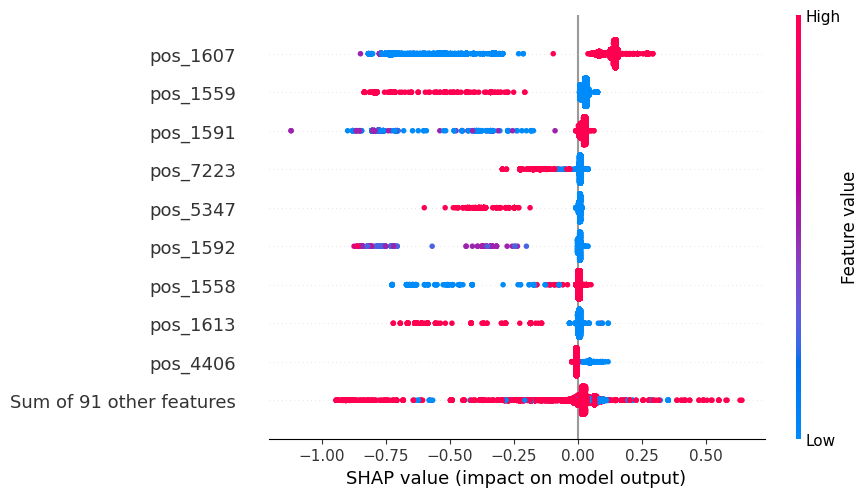

In [10]:
%matplotlib inline
shap.plots.beeswarm(shap_values[:, :, 0])  # same idea, pick one output

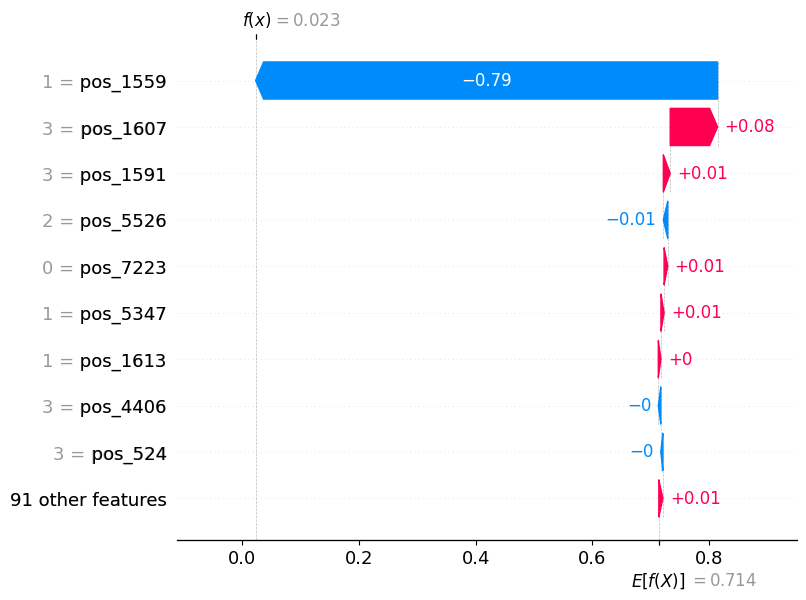

In [16]:
shap.plots.waterfall(shap_values[2,:,0])  # first sample, first output

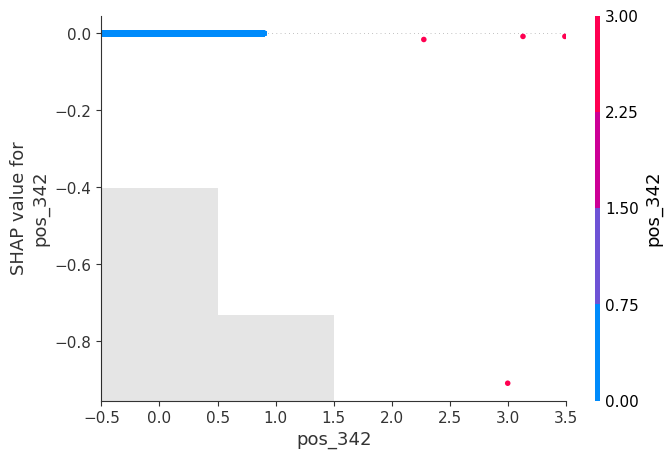

In [17]:

shap.plots.scatter(shap_values[:, "pos_342",0], color=shap_values[:, "pos_342",0])

Let's look at the contigency table. What isolates are still resistant but don't have the popular mutations?

In [27]:
import pandas as pd

df = pd.read_csv(r'C:\Users\Noah Legall\LegallLab\SHAP-mTB-AMR\scripts\rpoBC_fullseq.csv')
df

,pos_1,pos_2,pos_3,pos_4,pos_5,pos_6,pos_7,pos_8,pos_9,pos_10,...,pos_7902,pos_7903,pos_7904,pos_7905,pos_7906,pos_7907,pos_7908,pos_7909,pos_7910,phenotype
0,1,2,3,3,3,0,3,3,1,3,...,1,0,3,3,2,3,1,0,2,1
1,1,2,3,3,3,0,3,3,1,3,...,1,0,3,3,2,3,1,0,2,1
2,1,2,3,3,3,0,3,3,1,3,...,1,0,3,3,2,3,1,0,2,1
3,1,2,3,3,3,0,3,3,1,3,...,1,0,3,3,2,3,1,0,2,1
4,1,2,3,3,3,0,3,3,1,3,...,1,0,3,3,2,3,1,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17355,1,2,3,3,3,0,3,3,1,3,...,1,0,3,3,2,3,1,0,2,0
17356,1,2,3,3,3,0,3,3,1,3,...,1,0,3,3,2,3,1,0,2,0
17357,1,2,3,3,3,0,3,3,1,3,...,1,0,3,3,2,3,1,0,2,0
17358,1,2,3,3,3,0,3,3,1,3,...,1,0,3,3,2,3,1,0,2,0


In [28]:
pd.crosstab(df["phenotype"], df["pos_1559"])

pos_1559,0,1,2,3,4
phenotype,,,,,
0,12381,13,4,2,0
1,4361,489,95,9,6


## Interaction Analysis for SHAP values

In [48]:
explainer = shap.TreeExplainer(rf_small, feature_perturbation="interventional", feature_names=top_columns, approximate =True)
shap_values = explainer(X_top, check_additivity=False)

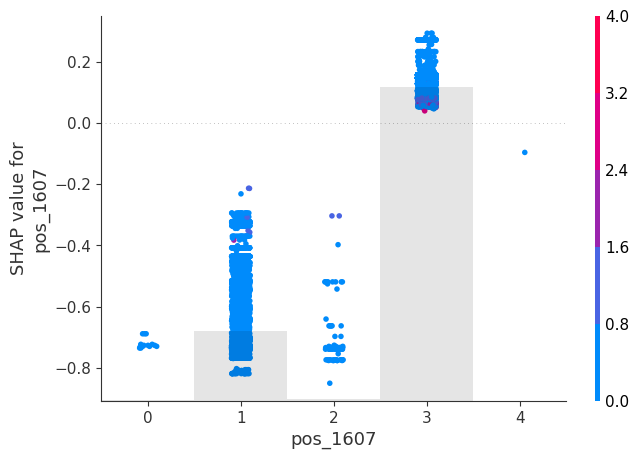

In [53]:
shap.plots.scatter(shap_values[:, "pos_1607", 0],color=X_top[:,top_columns.index("pos_1559")])

In [ ]:
import seaborn as sns
interaction_vals = explainer.shap_interaction_values(X_top)

A = interaction_vals[1]
A_mean = A.mean(axis=0)
sns.clustermap(A_mean, cmap="coolwarm", center=0)

In [ ]:
interaction_vals = explainer.shap_interaction_values(X_top)
A = interaction_vals[1]
adj = np.ascontiguousarray(A, dtype=np.float32)
mean_matrix = np.add.reduce(np.abs(adj), axis=0) / adj.shape[0]

In [18]:
# Conditional SHAP
# resistant despite dominate genotype

background = (
    data
    .filter(
        (pl.col("pos_1559") == 0) &
        (pl.col("phenotype") == 1)
    )
    .select(top_columns)
    .to_numpy()
)


In [19]:
mask = (X_top[:, top_columns.index("pos_1559")] == 0) & (y == 1)
X_discordant = X_top[mask]


explainer = shap.TreeExplainer(rf_small, feature_perturbation="interventional", feature_names=top_columns, data=background, approximate=True)
shap_values = explainer(X_discordant, check_additivity=False)

In [20]:
resistance_shap = shap_values.values  # shape: (n_samples, n_features)

mean_positive_effect = resistance_shap.mean(axis=0)
top_idx = np.argsort(mean_positive_effect)[-20:]


In [23]:
interaction_vals = explainer.shap_interaction_values(X_discordant)

In [35]:
print(interaction_vals[0][0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


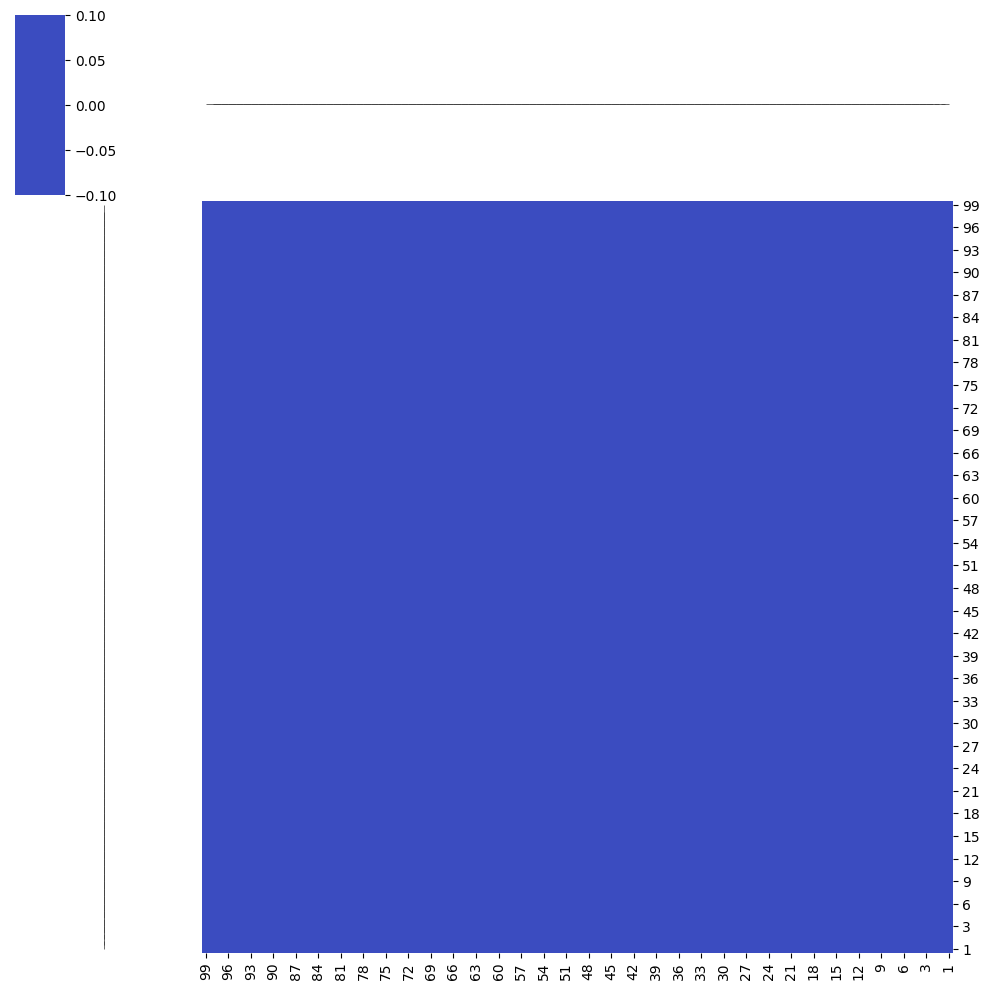

In [41]:
import seaborn as sns


A = interaction_vals[1]
A_mean = A.mean(axis=0)
sns.clustermap(A_mean, cmap="coolwarm", center=0)


In [42]:
# Mean interaction strength with pos_1559
pos_interactions = np.abs(interaction_vals[1]).mean(axis=0)

top_interactors = np.argsort(pos_interactions)[-10:]


In [45]:
print(pos_interactions)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


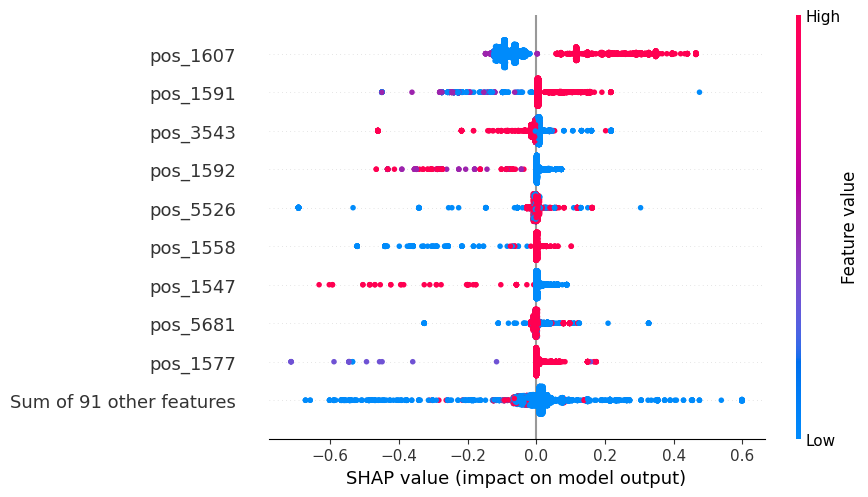

In [46]:
shap.plots.beeswarm(shap_values[:, :, 0])

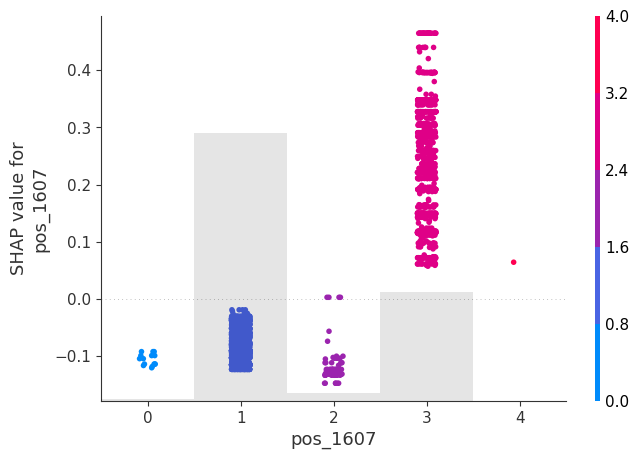

In [47]:
shap.plots.scatter(shap_values[:, "pos_1607", 0],color=X_discordant[:,top_columns.index("pos_1607")])
